# Sentiment Analysis on movie reviews

Hi 🙂, if you are seeing this notebook, you have succesfully started your first project on FloydHub 🚀, hooray!!

![sentiment](images/sentiment.png)

In this notebook we will build a classifier to predict the sentiment of movie reviewes. This type of task is really common for deriving usefull insight about the reputation of the product or the service managed by the company.

### Resource

The dataset was taken from [Stanford Large Movie Reviews](http://ai.stanford.edu/~amaas/data/sentiment/).

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification** task consists of predicting the polarity (positive or negative) of a given text.

**Note**

For executing a Code Cell, click on the Cell and run `Shift + Enter` (shortcut for Run).

## Initial Setup

Let's start by importing the packages, Setting the training variables and loading the csv file from which get all the data we need.

In [1]:
! pip -q install seaborn h5py==2.8.0rc1

train shape (rows, columns):  (25000, 2) , validation shape (rows, columns):  (25000, 2)

--- First Sample ---
Label: 0
Text: Watch the Original with the same title from 1944! This made for TV movie, is just god-awful! Although it does use (as far as I can tell) almost the same dialog, it just doesn't work! Is it the acting, the poor directing? OK so it's made for TV, but why watch a bad copy, when you can get your hands on the superb original? Especially as you'll be spoiled to the plot and won't enjoy the original as much, as if you've watched it first! <br /><br />There are a few things that are different from the original (it's shorter for once), but all are for the worse! The actors playing the parts here, just don't fit the bill! You just don't believe them and who could top Edward G. Robinsons performance from the original? If you want, only watch it after you've seen the original and even then you'll be very brave, if you watch it through! It's almost sacrilege!


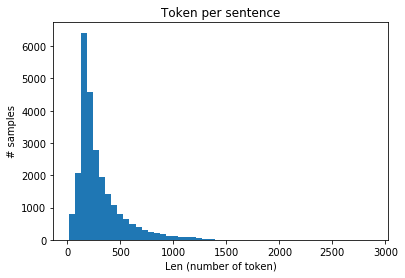

In [7]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, MaxPooling1D, Flatten, Conv1D
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

# Set training given hardware
if tf.test.is_gpu_available():
    BATCH_SIZE = 64
    EPOCHS = 2
    VOCAB_SIZE = 30000
    MAX_LEN = 500
    EMBEDDING = 32
    
else:
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 80
    EMBEDDING = 32

DS_PATH = '/floyd/data/imdb/' # ADD path/to/dataset
LABELS = ['negative', 'positive']

# Load data
train = pd.read_csv(os.path.join(DS_PATH,"train.tsv"), sep='\t')  # EDIT WITH YOUR TRAIN FILE NAME
val = pd.read_csv(os.path.join(DS_PATH,"val.tsv"), sep='\t')  # EDIT WITH YOUR VALIDATION FILE NAME

print("train shape (rows, columns): ", train.shape, ", validation shape (rows, columns): ",  val.shape)

# How a row/sample looks like
print("\n--- First Sample ---")
print('Label:', train['label'][0])
print('Text:', train['text'][0])

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in train['text'].values], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data Preprocessing

In [8]:
imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
imdb_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = imdb_tokenizer.texts_to_sequences(train['text'].values)
x_val_seq = imdb_tokenizer.texts_to_sequences(val['text'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['label'].values, val['label'].values

## Model

In [12]:
# Conv Model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING, input_length=MAX_LEN))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           960000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 16)           1552      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               400100    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 1,361,753
Trainable params: 1,361,753
Non-trainable params: 0
_________________________________________________________________


## Train & Evaluate

In [13]:
# fit a model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1)

# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('Accuracy: ', acc*100 )

pred = model.predict_classes(x_val)

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 3s 145us/step - loss: 0.4379 - acc: 0.7608 - val_loss: 0.2762 - val_acc: 0.8844
Epoch 2/2
25000/25000 [==============================] - 1s 36us/step
Accuracy:  86.7959999961853


             precision    recall  f1-score   support

   negative       0.91      0.84      0.87     13575
   positive       0.82      0.90      0.86     11425

avg / total       0.87      0.87      0.87     25000



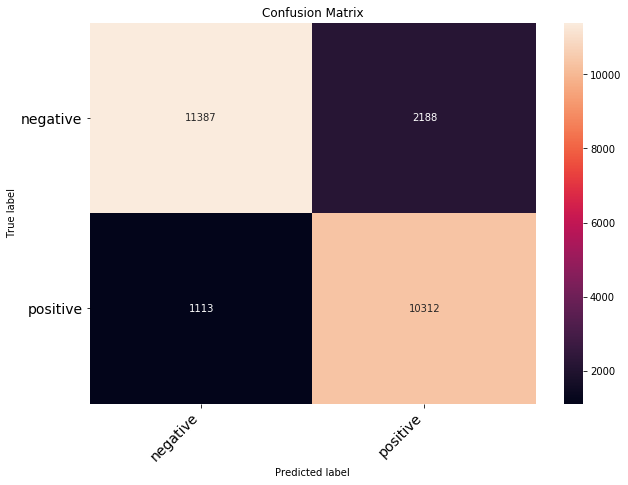

In [14]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix
cnf_matrix = confusion_matrix(pred, y_val)
_ = print_confusion_matrix(cnf_matrix, LABELS)

# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(pred, y_val, target_names=LABELS)
print(report)

## It's your turn

In [15]:
def get_prediction(text):
    review_np_array = imdb_tokenizer.texts_to_sequences([text])
    review_np_array = sequence.pad_sequences(review_np_array, maxlen=MAX_LEN, padding="post", value=0)
    prediction = model.predict_classes(review_np_array)
    return(prediction)

text_to_test = ['Star Wars episode 8 is the best movie I ever seen. Fan Service, Rebel vs Empire, Jedi battles, Luke and Y... AWESOME.',
               'A completely waste of my time',
               'worst movie ever',
               'Go to the cinema, now! You cannot miss this masterpiece']


for text in text_to_test:
    review_np_array = imdb_tokenizer.texts_to_sequences([text])
    review_np_array = sequence.pad_sequences(review_np_array, maxlen=MAX_LEN, padding="post", value=0)
    prediction = LABELS[model.predict_classes(review_np_array)[0][0]]
    print('TEXT:', text, ' - PREDICTION:', prediction)

TEXT: Star Wars episode 8 is the best movie I ever seen. Fan Service, Rebel vs Empire, Jedi battles, Luke and Y... AWESOME.  - PREDICTION: positive
TEXT: A completely waste of my time  - PREDICTION: negative
TEXT: worst movie ever  - PREDICTION: negative
TEXT: Go to the cinema, now! You cannot miss this masterpiece  - PREDICTION: positive


## Save the result

In [16]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(imdb_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Model Weight
model.save_weights('models/cnn_sentiment_weights.h5')

In [21]:
from ipywidgets import widgets

text = widgets.Text()
display(text)

def handle_submit(sender):
    print(get_prediction(text.value))
    
text.on_submit(handle_submit)

Text(value='')